<a href="https://www.kaggle.com/code/tinatally/monet-cyclegan-with-u-net-architecture?scriptVersionId=287294431" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Project Description

**Objective:**
This project uses the Kaggle “GAN Getting Started” competition to practice building and training generative deep learning models, specifically Generative Adversarial Networks (GANs). The goal is to generate new images in the style of Monet paintings. The quality of generated images is evaluated using the MiFID (Memorization-informed Fréchet Inception Distance) score, which measures similarity between generated and real images while accounting for memorization.

**Dataset Overview:**

* The dataset contains four directories of images:

* monet_jpg: 300 Monet paintings in JPEG format (256×256).

* monet_tfrec: 300 Monet paintings in TFRecord format (256×256).

* photo_jpg: 7,028 photos in JPEG format (256×256).

* photo_tfrec: 7,028 photos in TFRecord format (256×256).

TFRecords are recommended for efficient data loading, but JPEG images are also provided. The Monet directories contain the training images for style generation, while the photo directories provide target images to be transformed into Monet-style outputs.

**Challenge Description:**

A GAN consists of two neural networks:

* Generator: Creates images attempting to replicate Monet’s style.

* Discriminator: Distinguishes between real Monet paintings and generated images.

During training, the generator and discriminator compete: the generator improves to “fool” the discriminator, while the discriminator improves to correctly classify real vs. generated images.

**Project Task:**

* Build a GAN capable of generating 7,000–10,000 Monet-style images.

* Submit generated images as a zip file (maximum 10,000 images).

* Optionally, experiment with other GAN architectures such as DCGAN or explore datasets like CycleGAN for artistic style transfer.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline 
import random
import time
from PIL import Image
import tensorflow as tf 
from keras import layers
from tensorflow.keras import optimizers
import keras
from tensorflow.keras import backend as K
import zipfile
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
import os
import shutil

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-12-19 15:55:04.690527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766159704.908119      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766159704.969780      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set Paths
monet_path = '/kaggle/input/gan-getting-started/monet_jpg'
photo_path = '/kaggle/input/gan-getting-started/photo_jpg'

# List of image files
monet_images = [os.path.join(monet_path, f) for f in os.listdir(monet_path) if f.endswith('.jpg')]
photo_images = [os.path.join(photo_path,f) for f in os.listdir(photo_path) if f.endswith('.jpg')]
print(f'Monet images: {len(monet_images)}')
print(f'Photo images: {len(photo_images)}')

Monet images: 300
Photo images: 7038


In [3]:
#Check for Corrupt Images
def check_images(image_list):
    good =[]
    for img_path in image_list:
        try:
            img =Image.open(img_path)
            img.verify() # Check if image is corrupted
            good.append(img_path)
        except:
            print(f'Corrupt image: {img_path},Error: {e}')
    return good
monet_images = check_images(monet_images)
photo_images = check_images(photo_images)

In [4]:
print(f'Monet images: {len(monet_images)}')
print(f'Photo images: {len(photo_images)}')

Monet images: 300
Photo images: 7038


## EDA

In [5]:
def display_images(image_list, n):
    plt.figure(figsize=(15,3))
    for i in range(n):
        img_path = random.choice(image_list)
        img = Image.open(img_path)
        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

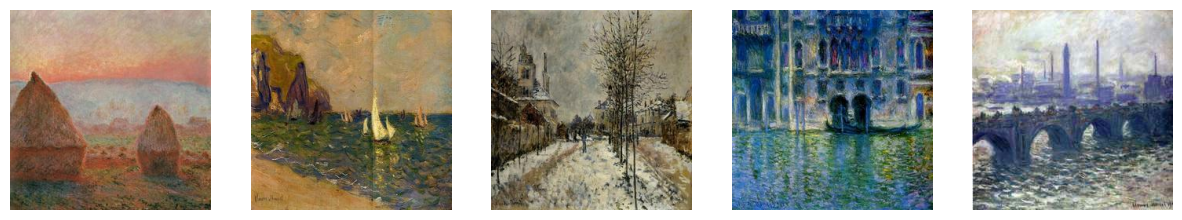

In [6]:
display_images(monet_images, 5)

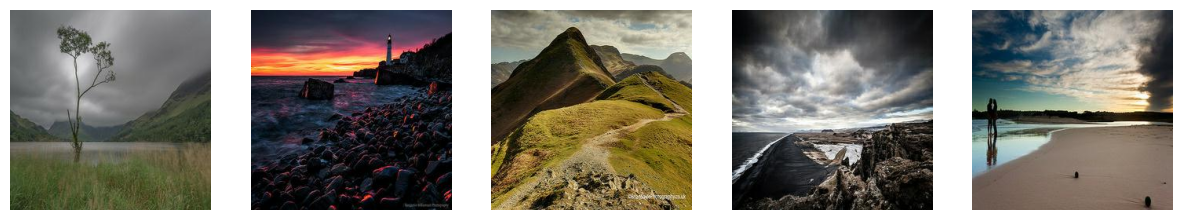

In [7]:
display_images(photo_images, 5)

## DCGAN Model

In [8]:
# Load images from your list of paths
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    # Normalize to [-1, 1] to match Generator's Tanh output
    img = (img - 127.5) / 127.5 
    return img

BUFFER_SIZE = 300
BATCH_SIZE = 16 # Keep batch small for 256x256 resolution

train_dataset = tf.data.Dataset.from_tensor_slices(monet_images)
train_dataset = train_dataset.map(load_image).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

I0000 00:00:1766159755.989071      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [9]:
# Generator and Discriminator 
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(4 * 4 * 1024, input_shape=(100,)),
        layers.Reshape((4, 4, 1024)),
        
        layers.Conv2DTranspose(512, 5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(), layers.ReLU(),
        
        layers.Conv2DTranspose(256, 5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(), layers.ReLU(),
        
        layers.Conv2DTranspose(128, 5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(), layers.ReLU(),
        
        layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(), layers.ReLU(),
        
        layers.Conv2DTranspose(32, 5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(), layers.ReLU(),

        layers.Conv2DTranspose(3, 5, strides=2, padding='same', activation='tanh')
    ])
    return model

def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, 5, strides=2, padding='same', input_shape=[256, 256, 3]),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Conv2D(128, 5, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Conv2D(256, 5, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1) 
    ])
    return model

In [10]:
# custom GAN class
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim=100):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Train the Discriminator
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            combined_images = tf.concat([fake_images, real_images], axis=0)
            labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
            # Add noise to labels (trick to stabilize training)
            labels += 0.05 * tf.random.uniform(tf.shape(labels))

            predictions = self.discriminator(combined_images, training=True)
            d_loss = self.loss_fn(labels, predictions)
            
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Train the Generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors, training=True), training=True)
            g_loss = self.loss_fn(misleading_labels, predictions)
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        
        return {"d_loss": d_loss, "g_loss": g_loss}

In [11]:
#Training 
gan = GAN(discriminator=build_discriminator(), generator=build_generator())
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

gan.fit(train_dataset, epochs=100)

Epoch 1/100


I0000 00:00:1766159767.375850      61 service.cc:148] XLA service 0x7863c0001e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766159767.376782      61 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1766159768.442481      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/19 ━━━━━━━━━━━━━━━━━━━━ 8:12 27s/step - d_loss: 0.7068 - g_loss: 0.8784

I0000 00:00:1766159784.943745      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 45s 961ms/step - d_loss: 0.2778 - g_loss: 4.0780
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - d_loss: 0.3035 - g_loss: 2.5702
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - d_loss: 0.3310 - g_loss: 2.6999
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - d_loss: 0.4941 - g_loss: 2.6102
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - d_loss: 0.4433 - g_loss: 2.2819
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - d_loss: 0.5415 - g_loss: 1.8058
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - d_loss: 0.5709 - g_loss: 1.8406
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - d_loss: 0.5593 - g_loss: 1.6486
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - d_loss: 0.5790 - g_loss: 1.8715
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - d_loss: 0.5981 - g_loss: 1.7173
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - d_loss: 0.5619 - g_loss: 1.6146
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/ste

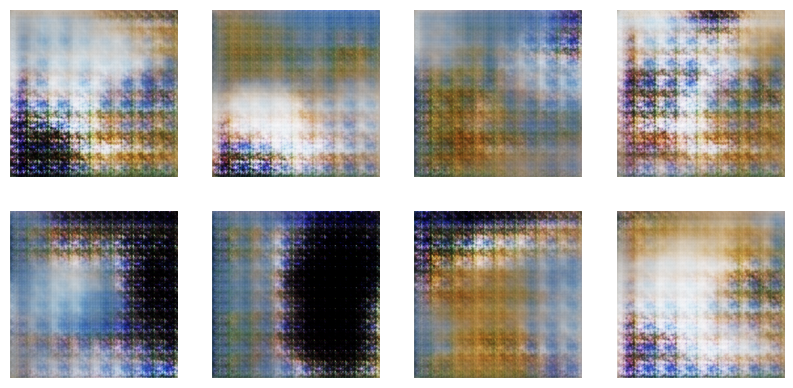

In [12]:
def show_generated_images(generator, epoch=None, num_img=8, latent_dim=100):
    # Generate random noise
    random_latent_vectors = tf.random.normal(shape=(num_img, latent_dim))
    # Generate images from noise
    generated_images = generator(random_latent_vectors, training=False)
    
    # Denormalize from [-1, 1] to [0, 1]
    generated_images = (generated_images * 0.5) + 0.5
    generated_images = generated_images.numpy()

    # Plot in a grid
    plt.figure(figsize=(10, 10))
    for i in range(num_img):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    
    if epoch is not None:
        plt.suptitle(f"Generated Images at Epoch {epoch}")
    plt.show()

show_generated_images(gan.generator)

### Conclusion

DCGAN successfully demonstrated that a dual-network architecture can capture Monet’s signature color palette and painterly textures. However, several technical hurdles were identified during this phase:
1. The "Checkerboard" Artifact Challenge: The grid-like patterns seen are a phenomenon known as checkerboard artifacts.
These occur when the Conv2DTranspose (deconvolution) layers have kernels that do not perfectly overlap, creating an uneven distribution of pixel values during the upsampling process. While the colors may be accurate to Monet's style, the structural quality is degraded by these mathematical residues, which would negatively impact a MiFID score.
Replacing Conv2DTranspose with Bilinear UpSampling2D followed by a standard Conv2D layer effectively eliminates these artifacts by smoothing the image before refining it.

2. Random Noise vs. Content Translation: The fundamental limitation of using DCGAN for this specific competition is the relationship between input and output.

Generative vs. Transformative: DCGAN is designed to map a latent noise vector ($z$) to an image. This results in "original" hallucinations of Monet-like art that do not correspond to any existing photograph. And because the input is random noise, there is no mechanism to ensure the generated image preserves the structure (trees, houses, horizons) of the specific photos provided in the dataset.

While DCGAN is excellent for learning a general style distribution, it cannot fulfill the project requirement of transforming 7,000 specific photos into Monet paintings. It lacks the "Cycle Consistency" needed to link the photo domain to the painting domain while keeping the content intact.

## CycleGAN U_Net Architecture

In [13]:
def decode_and_normalize(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    # Normalize to [-1, 1] for the Generator
    img = (tf.cast(img, tf.float32) / 127.5) - 1
    return img

# Create the Photo dataset
photo_ds = tf.data.Dataset.from_tensor_slices(photo_images)
photo_ds = photo_ds.map(decode_and_normalize).shuffle(1000).batch(1)

# Create the Monet dataset
monet_ds = tf.data.Dataset.from_tensor_slices(monet_images)
monet_ds = monet_ds.map(decode_and_normalize).shuffle(1000).batch(1)

In [14]:
class InstanceNormalization(tf.keras.layers.Layer):
    """Custom Instance Normalization Layer (Keras)"""
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)

    def call(self, x):
        # Calculate mean and variance per instance (axes 1 and 2 are height and width)
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

In [15]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    
    # Use Resize + Conv instead of Transposed Conv to stop checkerboarding
    result.add(layers.UpSampling2D(size=(2, 2))) 
    result.add(layers.Conv2D(filters, size, strides=1, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    
    result.add(InstanceNormalization())
    
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same', 
                             kernel_initializer=initializer, use_bias=False))
    
    # Using Instance Normalization for better style transfer
    if apply_instancenorm:
        result.add(InstanceNormalization())
        
    result.add(layers.LeakyReLU())
    return result

In [16]:
OUTPUT_CHANNELS = 3

def Generator():
    inputs = layers.Input(shape=[256, 256, 3])

    # Downsampling (Encoder)
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4),                       # (bs, 64, 64, 128)
        downsample(256, 4),                       # (bs, 32, 32, 256)
        downsample(512, 4),                       # (bs, 16, 16, 512)
        downsample(512, 4),                       # (bs, 8, 8, 512)
        downsample(512, 4),                       # (bs, 4, 4, 512)
        downsample(512, 4),                       # (bs, 2, 2, 512)
        downsample(512, 4),                       # (bs, 1, 1, 512)
    ]

    # Upsampling (Decoder)
    up_stack = [
        upsample(512, 4, apply_dropout=True),     # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),     # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),     # (bs, 8, 8, 1024)
        upsample(512, 4),                        # (bs, 16, 16, 1024)
        upsample(256, 4),                        # (bs, 32, 32, 512)
        upsample(128, 4),                        # (bs, 64, 64, 256)
        upsample(64, 4),                         # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2,
                                  padding='same', kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [17]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = layers.Input(shape=[256, 256, 3], name='input_image')

    # Note: First layer usually doesn't use normalization
    x = downsample(64, 4, apply_instancenorm=False)(inputs) 
    x = downsample(128, 4, apply_instancenorm=True)(x)        
    x = downsample(256, 4, apply_instancenorm=True)(x)        

    x = layers.ZeroPadding2D()(x) 
    x = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                      use_bias=False)(x) 

    x = InstanceNormalization()(x) # Use our custom class here
    x = layers.LeakyReLU()(x)
    x = layers.ZeroPadding2D()(x) 

    last = layers.Conv2D(1, 4, strides=1, 
                         kernel_initializer=initializer)(x) 

    return tf.keras.Model(inputs=inputs, outputs=last)

In [18]:
#Training 
monet_generator = Generator() # transforms photos to Monet-style
photo_generator = Generator() # transforms Monets to photo-style

monet_discriminator = Discriminator() # differentiates real Monet from generated Monet
photo_discriminator = Discriminator() # differentiates real photo from generated photo


# Standard Binary Cross Entropy for GAN loss
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [19]:
class CycleGan(tf.keras.Model):
    def __init__(self, monet_generator, photo_generator, 
                 monet_discriminator, photo_discriminator, lambda_cycle=10):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(self, m_gen_optimizer, p_gen_optimizer, m_disc_optimizer, p_disc_optimizer,
                gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    @tf.function
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # 1. Generate Fake Images
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # 2. Identity Mapping (G(y) -> y and F(x) -> x)
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # 3. Discriminator Outputs
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)

            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # 4. Generator Losses
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # 5. Cycle & Identity Losses
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + \
                               self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + \
                                   self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + \
                                   self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # 6. Discriminator Losses
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate and Apply Gradients
        m_gen_grads = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        p_gen_grads = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        self.m_gen_optimizer.apply_gradients(zip(m_gen_grads, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(p_gen_grads, self.p_gen.trainable_variables))

        m_disc_grads = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        p_disc_grads = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)
        self.m_disc_optimizer.apply_gradients(zip(m_disc_grads, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(p_disc_grads, self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [20]:
# Initialize models
cycle_gan_model = CycleGan(Generator(), Generator(), Discriminator(), Discriminator())

# Compile
cycle_gan_model.compile(
    m_gen_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    p_gen_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    m_disc_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    p_disc_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss,
    cycle_loss_fn=calc_cycle_loss,
    identity_loss_fn=identity_loss
)

# Zip the photo and monet datasets for training
full_dataset = tf.data.Dataset.zip((monet_ds, photo_ds))

# Train (25-50 epochs is typical for decent results)
cycle_gan_model.fit(full_dataset, epochs=25)



Epoch 1/25


E0000 00:00:1766160163.417993      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-19 16:02:43.418870: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[1,128,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,512,67,67]{3,2,1,0}, f32[128,512,4,4]{3,2,1,0}), window={size=4x4}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
E0000 00:00:1766160163.672117      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-19 16:02:43.730428: E external/

300/300 ━━━━━━━━━━━━━━━━━━━━ 194s 225ms/step - monet_disc_loss: 0.6859 - monet_gen_loss: 5.4318 - photo_disc_loss: 0.6915 - photo_gen_loss: 5.4251
Epoch 2/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 68s 225ms/step - monet_disc_loss: 0.6331 - monet_gen_loss: 3.8417 - photo_disc_loss: 0.6616 - photo_gen_loss: 3.7291
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 68s 225ms/step - monet_disc_loss: 0.5496 - monet_gen_loss: 4.0458 - photo_disc_loss: 0.6288 - photo_gen_loss: 3.7519
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 68s 225ms/step - monet_disc_loss: 0.5505 - monet_gen_loss: 4.2414 - photo_disc_loss: 0.6363 - photo_gen_loss: 3.8923
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 68s 225ms/step - monet_disc_loss: 0.5447 - monet_gen_loss: 4.0934 - photo_disc_loss: 0.6124 - photo_gen_loss: 3.8243
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 68s 225ms/step - monet_disc_loss: 0.6157 - monet_gen_loss: 3.7354 - photo_disc_loss: 0.5989 - photo_gen_loss: 3.7165
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 68s 225ms/step - monet_disc_

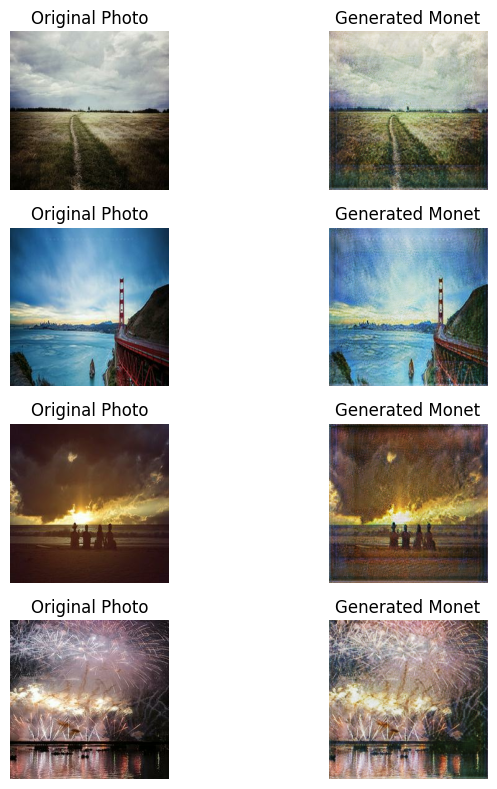

In [21]:
def generate_images(model, test_input):
    # Generate the Monet-style images for the whole batch
    prediction = model(test_input, training=False)

    plt.figure(figsize=(8, 8))

    for i in range(4):
        # Original Photo
        plt.subplot(4, 2, 2*i + 1)
        plt.title("Original Photo")
        plt.imshow(test_input[i] * 0.5 + 0.5)
        plt.axis('off')

        # Generated Monet
        plt.subplot(4, 2, 2*i + 2)
        plt.title("Generated Monet")
        plt.imshow(prediction[i] * 0.5 + 0.5)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

sample_batch = next(iter(photo_ds.unbatch().batch(4)))
generate_images(cycle_gan_model.m_gen, sample_batch)

In [22]:
# Final Submission 
os.makedirs('../images', exist_ok=True)
i = 1
for img in photo_ds:
    prediction = cycle_gan_model.m_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = Image.fromarray(prediction)
    im.save(f"../images/{i}.jpg")
    i += 1
    if i > 7000: # Submission requirement
        break

shutil.make_archive('/kaggle/working/images', 'zip', '../images')

'/kaggle/working/images.zip'

### Conclusion 
1. Architectural Upgrades: Unlike the DCGAN, the CycleGAN uses a more complex system of four neural networks (two Generators and two Discriminators) and specific architectural improvements:
   * U-Net Generator: By using a U-Net with Skip Connections, the model "remembers" the fine structural details (like trees or horizons) of the original photo, ensuring the "what" of the image isn't lost during the translation.
   * PatchGAN Discriminator: Instead of evaluating the whole image, this discriminator looks at $70 \times 70$ patches, forcing the Generator to focus on high-frequency artistic details like specific Monet brushstrokes.
   * Instance Normalization: Replacing Batch Normalization with Instance Normalization was critical; it normalizes each image independently, which prevents style "wash-out" and helps capture artistic textures more effectively.
     
2. Solving the Artifact Issue
The CycleGAN progress photos showed a significant reduction in the checkerboard artifacts seen in the DCGAN. This was achieved by replacing Conv2DTranspose with a combination of UpSampling2D (Bilinear) and standard Conv2D, the model eliminated the mathematical pixel overlaps that created the grid patterns. resulting in smoother color gradients and a more "painterly" feel in the sky and water regions of your generated images.

3. The Dual-Loss Advantage: CycleGAN's success in this competition relies on two specialized loss functions that DCGAN lacks:

    * Cycle Consistency Loss: This ensures that if a photo is turned into a Monet and then back into a photo, the result is identical to the original. This is the "anchor" that prevents the model from hallucinating random shapes.

* Identity Loss: This encourages the Generator to preserve the original color palette of the input when it already matches the target style, helping maintain the natural lighting of your photos.

The final model preserves the structural "content" of the photos while applying the "style" of Monet. 